In [ ]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, classification_report

def parse_label_from_filename(filename):
    filename = filename.replace('.jpg', '')
    fields = filename.split('-')
    if len(fields) >= 7:
        try:
            return int(fields[6].split('_')[0])
        except ValueError:
            print(f"Warnung: Label konnte nicht in Integer umgewandelt werden: {fields[6]}")
    else:
        print(f"Warnung: Unerwartetes Format des Dateinamens: {filename}")
    return None

def load_images_and_labels(base_dir, file_name, image_subfolder, img_size=(360, 180)):
    print("test")
    images, labels = [], []
    file_path = os.path.join(base_dir, file_name)
    image_dir = os.path.join(base_dir, image_subfolder)
    print(image_dir)
    with open(file_path, 'r') as f:
        for line in f:
            img_name = line.strip()
            label = parse_label_from_filename(img_name)
            if label is None:
                continue
            
            img_path = os.path.join(image_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warnung: Bild nicht gefunden oder lesbar: {img_path}")
                continue
            
            img_resized = cv2.resize(img, img_size)
            images.append(img_resized)
            labels.append(label)
            print(img_resized, " geladen")
    print("Alle Bilder geladen!")
    return np.array(images), np.array(labels)

def extract_hog_features(images):
    return np.array([hog(img, orientations=12, pixels_per_cell=(8, 8),
                         cells_per_block=(3, 3), block_norm='L2-Hys') for img in images])

def evaluate_model(model, X, y, dataset_name):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    print(f"{dataset_name} Accuracy: {acc * 100:.2f}%")
    if dataset_name == "Test":
        print("\nClassification Report:\n", classification_report(y, y_pred))

# Verzeichnisnamen
base_dir = "../dataset/CCPD2020/ccpd_green"
datasets = {
    "train": ("train/file_names.txt", "train/images"),
    "val": ("val/file_names.txt", "val/images"),
    "test": ("test/file_names.txt", "test/images")
}
print("test1233")
# Lade Daten mit der neuen Bildgröße (360x180)
X_train, y_train = load_images_and_labels(base_dir, *datasets["train"], img_size=(360, 180))
X_val, y_val = load_images_and_labels(base_dir, *datasets["val"], img_size=(360, 180))
X_test, y_test = load_images_and_labels(base_dir, *datasets["test"], img_size=(360, 180))

# Extrahiere HOG-Features
X_train_hog, X_val_hog, X_test_hog = map(extract_hog_features, [X_train, X_val, X_test])

# Mehrere Trainingsdurchläufe mit Datenmischung
num_epochs = 10
best_model = None
best_val_acc = 0

for epoch in range(num_epochs):
    print(f"\n🔄 Training Epoch {epoch+1}/{num_epochs}...")
    
    # Mische die Daten mit Seed für Reproduzierbarkeit
    X_train_hog, y_train = shuffle(X_train_hog, y_train, random_state=42)

    # Trainiere das SVM-Modell mit verbessertem Kernel
    svm = SVC(kernel='rbf', probability=True, C=10, gamma='scale')  
    svm.fit(X_train_hog, y_train)

    # Validierung nach jeder Epoche
    y_val_pred = svm.predict(X_val_hog)
    val_acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy after epoch {epoch+1}: {val_acc * 100:.2f}%")

    # Bestes Modell speichern
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = svm

# Finales Testen mit dem besten Modell
print("\n🏆 Best model evaluation on test set:")
evaluate_model(best_model, X_test_hog, y_test, "Test")


test1233
test
../dataset/CCPD2020/ccpd_green\train/images
[[197 198 198 ...  38  41  38]
 [200 200 200 ...  48  47  46]
 [203 199 205 ...  45  45  42]
 ...
 [ 76  77  76 ...  75  80  81]
 [ 68  72  72 ...  67  73  72]
 [ 61  60  59 ...  68  72  78]]  geladen
[[ 37  37  37 ... 198 198 198]
 [ 38  38  38 ... 198 198 198]
 [ 38  38  38 ... 197 198 198]
 ...
 [ 18  18  18 ...  68  68  68]
 [ 16  16  16 ...  68  67  66]
 [  8   8   8 ...  67  60  55]]  geladen
[[247 250 250 ...  43  41  39]
 [232 231 231 ...  45  35  32]
 [143 147 149 ...  36  29  29]
 ...
 [ 45  44  46 ...  77  75  75]
 [ 59  56  55 ...  72  72  75]
 [ 50  56  58 ...  78  78  76]]  geladen
[[ 91  69  53 ... 168 168 168]
 [ 58  66  78 ... 155 155 155]
 [ 83  79  91 ... 153 153 153]
 ...
 [ 58  58  58 ...  68  68  68]
 [ 58  58  58 ...  86  86  86]
 [ 58  58  58 ...  78  78  78]]  geladen
[[ 66  78  88 ...   9  16  15]
 [ 78  79 100 ...   5  15  23]
 [ 73  75  97 ...  15  35  24]
 ...
 [ 48  49  47 ... 213 211 205]
 [ 42  47

In [2]:
import joblib

# Modell speichern
model_filename = 'svm_model.joblib'
joblib.dump(best_model, model_filename)
print(f"Modell wurde gespeichert unter: {model_filename}")


Modell wurde gespeichert unter: svm_model.joblib


In [3]:
# Modell laden
import joblib
loaded_model = joblib.load('svm_model.joblib')
print("Modell wurde erfolgreich geladen!")

# Vorhersagen mit dem geladenen Modell
y_test_pred = loaded_model.predict(X_test_hog)


Modell wurde erfolgreich geladen!


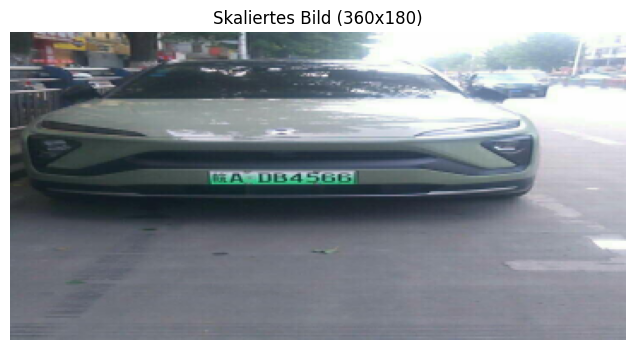

In [7]:
import cv2
import matplotlib.pyplot as plt

# Bildpfad (ändere diesen zu deinem Testbild)
image_path = r"C:\Users\maure\Desktop\Programming-for-Modern-Machine-Learning\dataset\CCPD2020\ccpd_green\test\images\01-90_265-231&522_405&574-405&571_235&574_231&523_403&522-0_0_3_1_28_29_30_30-134-56.jpg"

# Bild einlesen
img = cv2.imread(image_path, cv2.IMREAD_COLOR)

# Überprüfen, ob das Bild geladen wurde
if img is None:
    print(f"Fehler: Bild konnte nicht geladen werden ({image_path})")
else:
    # Bild auf 360x180 skalieren
    img_resized = cv2.resize(img, (360, 180), interpolation=cv2.INTER_AREA)

    # Bild in RGB umwandeln für korrekte Anzeige mit Matplotlib
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    # Bild anzeigen
    plt.figure(figsize=(8, 4))
    plt.imshow(img_rgb)
    plt.axis("off")  # Achsen ausblenden
    plt.title("Skaliertes Bild (360x180)")
    plt.show()
